In [21]:
import os
from pathlib import Path
from typing import List, Optional, Union, Any

import pytorch_lightning as pl
import torch
from PIL import Image as PILImage
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.transforms import v2
from torchvision.tv_tensors import Image, Mask
from torchvision import tv_tensors


class SegmentationDataset(VisionDataset):
    """Load preprocessed image chips. Used during model train and validation phases."""

    def __init__(self, root: str, *args, ext: str = "tif", **kwargs):
        super().__init__(root, *args, **kwargs)

        self._images = sorted(Path(root).joinpath("x").glob(f"*.{ext}"))
        self._labels = sorted(Path(root).joinpath("y").glob(f"*.{ext}"))

        assert len(self._images) == len(
            self._labels
        ), "There are an unequal number of images and labels!"

    def __len__(self):
        return len(self._images)

    # noinspection DuplicatedCode
    def __getitem__(self, idx):
        img = Image(PILImage.open(self._images[idx]))
        target = Mask(PILImage.open(self._labels[idx]))

        if self.transforms is not None:
            with torch.no_grad():
                img, target = self.transforms(img, target)

        return img, target


class PadOut(object):
    def __init__(self, height: int = 128, width: int = 128, fill_value: int = 0):
        self.height = height
        self.width = width
        self.fill_value = fill_value

    def __call__(self, x: Any) -> Any:
        """
        Pad out a pillow image, so it is the correct size as specified by `self.height` and `self.width`
        """
        h, w = x.shape[-2:]

        if h == self.height and w == self.width:
            return x

        w_pad = self.width - w
        h_pad = self.height - h

        return tv_tensors.wrap(
            v2.functional.pad(x, [0, 0, w_pad, h_pad], fill=self.fill_value), like=x
        )


def normalize_min_max(x: torch.Tensor) -> torch.Tensor:
    mask = torch.all(x == 0, dim=0).unsqueeze(dim=0).repeat(x.shape[0], 1, 1)
    masked_values = x.flatten()[~mask.flatten()]

    min_ = masked_values.min()
    max_ = masked_values.max()
    return tv_tensors.wrap(torch.clamp((x - min_) / (max_ - min_), 0, 1), like=x)


def normalize_min_max2(x: torch.Tensor) -> torch.Tensor:
    # Get second smallest values to accomodate black backgrounds/nodata areas
    min_, _ = torch.kthvalue(x.flatten().unique(), 2)
    max_ = x.flatten().max()
    return tv_tensors.wrap(torch.clamp((x - min_) / (max_ - min_), 0, 1), like=x)


def normalize_percentile(x: torch.Tensor, upper=0.99, lower=0.01) -> torch.Tensor:
    mask = torch.all(x == 0, dim=0).unsqueeze(dim=0).repeat(x.shape[0], 1, 1)
    masked_values = x.flatten()[~mask.flatten()]

    max_ = torch.quantile(masked_values, upper)
    min_ = torch.quantile(masked_values, lower)
    return tv_tensors.wrap(torch.clamp((x - min_) / (max_ - min_), 0, 1), like=x)


def append_ndvi(x: torch.Tensor) -> torch.Tensor:
    r, g, b, nir = x
    ndvi = torch.nan_to_num(torch.div((nir - r), (nir + r)))

    # Scale NDVI from [-1, 1] to [0, 255]
    ndvi = (((ndvi + 1) / 2.0) * 255).to(torch.uint8)

    new_x = torch.concat((x, ndvi.unsqueeze(dim=0)), dim=0)
    return tv_tensors.wrap(new_x, like=x)


# normalize = t.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


# noinspection PyAbstractClass
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str,
        num_classes: int,
        batch_size: int,
        num_workers: int = os.cpu_count(),
        pin_memory: bool = True,
        persistent_workers: bool = False,
        fill_value: int = 0,
        tile_size: int = 1024,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.persistent_workers = persistent_workers
        self.fill_value = fill_value
        self.tile_size = tile_size

        self.train_data_dir = Path(data_dir).joinpath("train")
        self.val_data_dir = Path(data_dir).joinpath("val")
        self.test_data_dir = Path(data_dir).joinpath("test")

        self.pad_f = PadOut(self.tile_size, self.tile_size, fill_value=self.fill_value)

        self.train_trans = v2.Compose(
            [
                v2.RandomHorizontalFlip(),
                v2.RandomVerticalFlip(),
                # t.RandomRotation(degrees=15, fill=self.fill_value),
                # t.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                # v2.Lambda(self.pad_f, Image, Mask),
                # v2.Lambda(append_ndvi, Image),
                v2.Lambda(normalize_min_max2, Image),
                v2.Lambda(v2.ToDtype(torch.float16, scale=True), Image),
                v2.Lambda(v2.ToDtype(torch.long), Mask),
                v2.Lambda(torch.squeeze, Mask),
            ]
        )

        self.test_trans = v2.Compose(
            [
                # v2.Lambda(self.pad_f, Image, Mask),
                # v2.Lambda(append_ndvi, Image),
                v2.Lambda(normalize_min_max2, Image),
                v2.Lambda(v2.ToDtype(torch.float16, scale=True), Image),
                v2.Lambda(v2.ToDtype(torch.long), Mask),
                v2.Lambda(torch.squeeze, Mask),
            ]
        )

        self.ds_train, self.ds_val, self.ds_test = None, None, None

    def prepare_data(self, *args, **kwargs):
        pass

    def setup(self, stage: Optional[str] = None):
        self.ds_train = SegmentationDataset(
            self.train_data_dir,
            ext="tif",
            transforms=self.train_trans,
        )
        self.ds_val = SegmentationDataset(
            self.val_data_dir,
            ext="tif",
            transforms=self.test_trans,
        )
        self.ds_test = SegmentationDataset(
            self.test_data_dir,
            ext="tif",
            transforms=self.test_trans,
        )

    def teardown(self, stage: Optional[str] = None) -> None:
        del self.ds_train
        del self.ds_val
        del self.ds_test

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(
            self.ds_train,
            shuffle=True,
            batch_size=self.batch_size,
            pin_memory=self.pin_memory,
            drop_last=True,
            num_workers=self.num_workers,
            persistent_workers=self.persistent_workers,
        )

    def val_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.ds_val,
            shuffle=False,
            batch_size=self.batch_size,
            pin_memory=self.pin_memory,
            num_workers=self.num_workers,
            persistent_workers=self.persistent_workers,
        )

    def test_dataloader(self, *args, **kwargs) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.ds_test,
            shuffle=False,
            batch_size=self.batch_size,
            pin_memory=self.pin_memory,
            num_workers=self.num_workers,
            persistent_workers=self.persistent_workers,
        )

In [22]:
d = DataModule(
    data_dir="/home/taylor/data/KP-ACO-RGBI-Nov2023",
    num_classes=3,
    batch_size=4,
    num_workers=1,
    pin_memory=False,
    persistent_workers=False,
    fill_value=0,
    tile_size=1024,
)

In [23]:
torch.manual_seed(42)

d.setup()

In [24]:
td = d.train_dataloader()

In [25]:
for x, y in td:
    x = x
    y = y
    break

In [26]:
d.ds_train

Dataset SegmentationDataset
    Number of datapoints: 70944
    Root location: /home/taylor/data/KP-ACO-RGBI-Nov2023/train
    Compose(
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
      Lambda(normalize_min_max2, types=['Image'])
      Lambda(
    types=['Image']
    (lambd): ToDtype(scale=True)
  )
      Lambda(
    types=['Mask']
    (lambd): ToDtype(scale=False)
  )
      Lambda(squeeze, types=['Mask'])
)

In [27]:
print(x.shape, y.shape)
print(x.dtype, y.dtype)

torch.Size([4, 4, 1024, 1024]) torch.Size([4, 1024, 1024])
torch.float16 torch.uint8


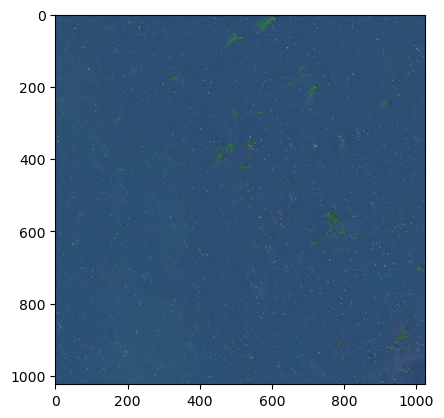

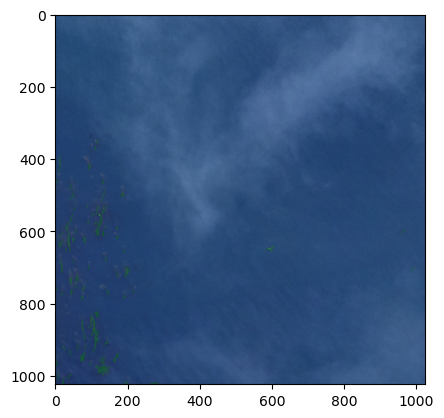

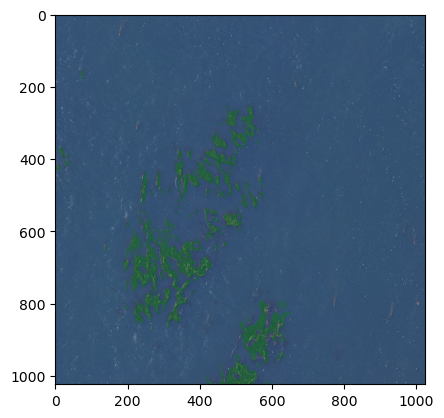

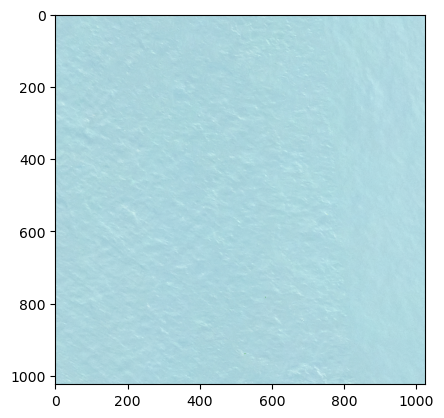

In [19]:
import matplotlib.pyplot as plt
import torchvision


def vis_image(img, label):
    masks = torch.nn.functional.one_hot(label.to(torch.int64), num_classes=3)[
        :, :, :, 1:
    ].to(torch.bool)

    for x, y in zip(img, masks):
        x = v2.functional.to_dtype(x, torch.uint8, scale=True)[:3]
        y = y.moveaxis(2, 0)

        im = torchvision.utils.draw_segmentation_masks(
            x, y, colors=["green", "yellow", "blue", "red"], alpha=0.4
        )

        plt.figure()
        plt.imshow(im.moveaxis(0, 2))
        plt.show()


vis_image(x, y)

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(10, 10))

im = x[1]
axis[0].imshow(im[:3].moveaxis(0, 2))
axis[0].set_title("Raw")

im2 = normalize_min_max(im.clone())
axis[1].imshow(im2[:3].moveaxis(0, 2))
axis[1].set_title("minmax")

im3 = normalize_percentile(im.clone(), upper=0.99, lower=0.01)
axis[2].imshow(im3[:3].moveaxis(0, 2))
axis[2].set_title("1/99 perc.")

plt.show()